# **Proyecto 1 - Etapa 1**

## **Importaciones**

In [1]:
import re
import unicodedata

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from nltk import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('spanish')
wpt = nltk.WordPunctTokenizer()
ps = PorterStemmer()
import re
import unicodedata
from collections import Counter

import nltk
import pandas as pd
import seaborn as sns
import spacy
from langdetect import detect
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\juanc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Entendimiento y Preparación de los Datos**

### **Entendimiento**

In [2]:
original_data = pd.read_excel('data/Datos_proyecto.xlsx')

print("Dimensiones:", original_data.shape, "\n")

print("Tipos de datos por columna:")
print(original_data.dtypes)

display(original_data.head())

print("\nValores únicos por columna:")
print(original_data.nunique())

Dimensiones: (2424, 2) 

Tipos de datos por columna:
textos    object
labels     int64
dtype: object


,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3



Valores únicos por columna:
textos    2424
labels       3
dtype: int64


El conjunto de datos únicamente tiene 2 columnas. A continuación, se define el diccionario de datos a partir de la información proveida en el enunciado y de la inspección inicial de los encabezados del conjunto de datos.

| Atributo | Descripción |
|----------|-------------|
| textos | String conteniendo opiniones de la ciudadanía provenientes de distintas fuentes vinculadas a la planificación participativa territorial. |
| labels | Integer $\in$ {1, 3, 4} que indica el objetivo de desarrollo sostenible (ODS) para el cual es más relevante la opinión dada en un texto; 1 es "Fin de la pobreza", 3 es "Salud y bienestar" y 4 es "Educación de calidad". |

Hay 2424 filas y 2 columnas. La columna de textos está guardada como el tipo genérico object, pero esto se cambiara en la etapa de validez. Adicionalmente, todos los textos son únicos y solo hay 3 clases en la variable objetivo, lo cual es correcto puesto que, según el enunciado, solo deben clasificarse las opiniones en los ODS 1, 3 y 4.

Inicialmente, se observa que en los datos proveídos y en el contexto del enunciado no se especificó:
- Los posibles idiomas de los textos, pero se preguntó y se confirmó que todos los textos estarán en español.
- Si hay longitudes mínimas o máximas para los textos.
- Si los textos pueden contener carácteres especiales.
- El contexto geográfico y demográfico del que provienen los textos.
- Los criterios usados para asignar las etiquetas a los textos.

Estas limitaciones deberán ser tomadas en cuenta en el perfilamiento y preprocesamiento y, eventualmente, en el análisis puesto que pueden influir en la interpretación de resultados y en la validez de los métodos aplicados.

In [3]:
#TODO: Cambiar lo de si los textos son en español en caso de que digan que no.
#TODO: Lo de las longitudes.

### **Perfilamiento de los Datos**

Como en el entendimiento se verificó que efectivamente solo aparecen los labels 1, 3 y 4, se procede a revisar la distribución de las clases.

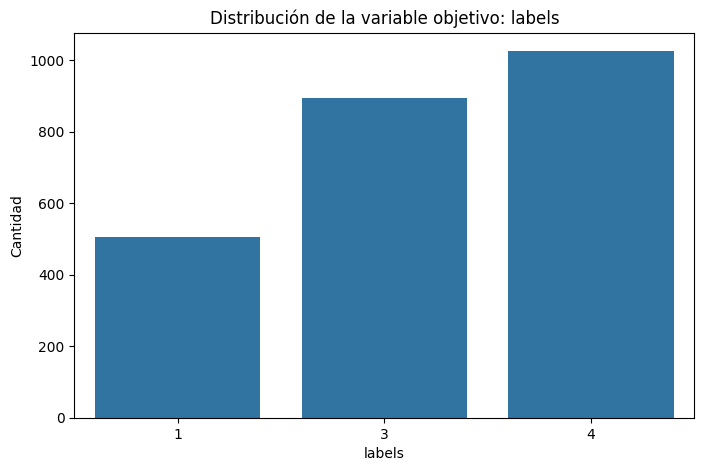

labels
4    1025
3     894
1     505
Name: count, dtype: int64


In [4]:
plt.figure(figsize=(8, 5))
sns.countplot(data=original_data, x='labels')
plt.title('Distribución de la variable objetivo: labels')
plt.ylabel('Cantidad')
plt.show()

label_counts = original_data['labels'].value_counts()
print(label_counts)

Hay desbalance en las clases, siendo la clase 4 la más representada con 1025 filas, seguida por la clase 3 con 894 filas y finalmente por la clase 1 con 505 filas. Esto puede afectar el rendimiento del modelo, sin embargo, la aumentación de datos para intentar balancear las clases se hará hasta la etapa 2 del proyecto.

Dado que en el entendimiento se verificó que los textos son únicos, se procede a revisar varias carácterísticas de los textos para entender mejor el conjunto de datos.

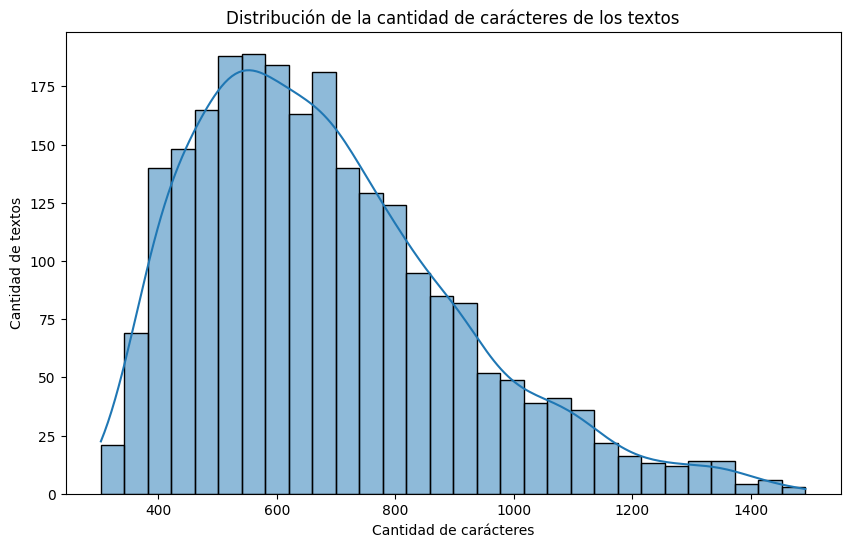

Estadísticas descriptivas de la cantidad de carácteres de los textos:
count    2424.000000
mean      683.223185
std       223.563695
min       303.000000
25%       513.000000
50%       647.000000
75%       809.250000
max      1492.000000
Name: textos, dtype: float64


In [5]:
text_character_counts = original_data['textos'].str.len()
plt.figure(figsize=(10, 6))
sns.histplot(text_character_counts, bins=30, kde=True)
plt.title('Distribución de la cantidad de carácteres de los textos')
plt.xlabel('Cantidad de carácteres')
plt.ylabel('Cantidad de textos')
plt.show()

print("Estadísticas descriptivas de la cantidad de carácteres de los textos:")
print(text_character_counts.describe())

In [6]:
#TODO: Escribir análisis

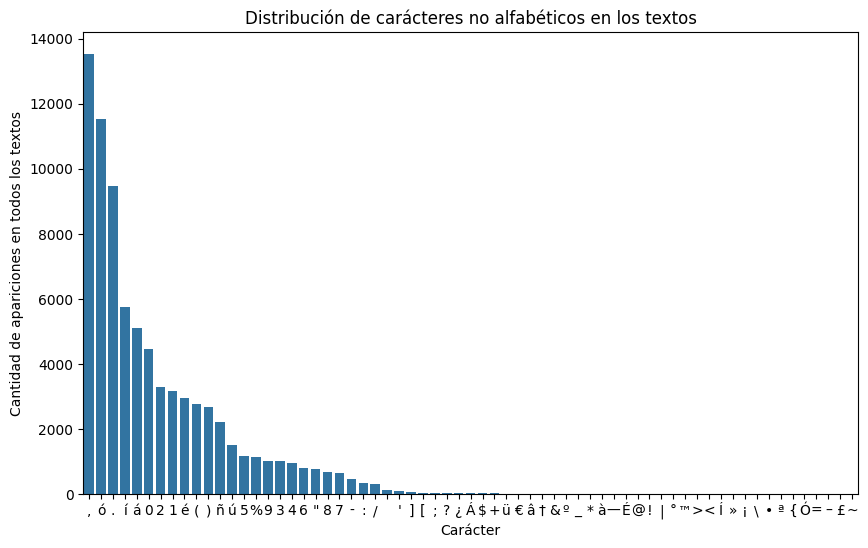

   character  count
3          ,  13523
1          ó  11535
2          .   9458
9          í   5747
4          á   5101
..       ...    ...
52         Ó      1
61         =      1
62         –      1
63         £      1
64         ~      1

[65 rows x 2 columns]
Estadísticas descriptivas de la cantidad de carácteres no alfabéticos:
count       65.000000
mean      1207.000000
std       2650.596425
min          1.000000
25%          4.000000
50%         32.000000
75%       1008.000000
max      13523.000000
Name: count, dtype: float64


In [7]:
text_non_alpha_chars = original_data['textos'].str.findall(r'[^a-zA-Z\s]', flags=re.UNICODE)
all_non_alpha_chars = [char for sublist in text_non_alpha_chars for char in sublist]
non_alpha_char_counts = Counter(all_non_alpha_chars)

non_alpha_char_counts_df = pd.DataFrame(non_alpha_char_counts.items(), columns=['character', 'count']).sort_values(by='count', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=non_alpha_char_counts_df, x='character', y='count')
plt.title('Distribución de carácteres no alfabéticos en los textos')
plt.xlabel('Carácter')
plt.ylabel('Cantidad de apariciones en todos los textos')
plt.show()

print(non_alpha_char_counts_df)

print("Estadísticas descriptivas de la cantidad de carácteres no alfabéticos:")
print(non_alpha_char_counts_df['count'].describe())

Hay una cantidad importante de caracteres especiales en los textos, esto es importante tenerlo en cuenta al momento de normalizar los textos.

In [8]:
text_character_counts

0       352
1       516
2       659
3       693
4       608
       ... 
2419    741
2420    541
2421    352
2422    754
2423    593
Name: textos, Length: 2424, dtype: int64

In [9]:
text_non_alpha_chars

0       [", ", ", ó, ", ó, ó, ., ,, ó, ,, ó, ,, ., ó, ...
1       [ñ, á, ñ, (, é, ñ, ñ, ), ,, ó, á, á, ó, ., á, ...
2       [á, ,, ó, é, á, ú, ,, (, ,, 2, 0, 1, 3, ), ., ...
3              [í, ,, ., ó, ., ,, ,, ., á, é, é, ó, ,, .]
4       [ó, (, ,, à, á, á, ), ., 9, 0, ó, ,, ó, ñ, ", ...
                              ...                        
2419    [í, á, ñ, ó, ,, é, ñ, é, ., (, -, ,, ), ,, ,, ...
2420    [:, ó, ., (, ), ​, ​, ó, á, ñ, ,, ,, ., é, á, ...
2421        [2, 0, 1, 0, ,, ó, ., í, 1, ., á, ó, :, á, .]
2422    [,, í, é, ., ó, ú, ó, ,, í, ., ,, (, ), ó, ó, ...
2423    [í, ,, (, é, é, ), ,, á, (, (, ó, ó, ), ,, 2, ...
Name: textos, Length: 2424, dtype: object

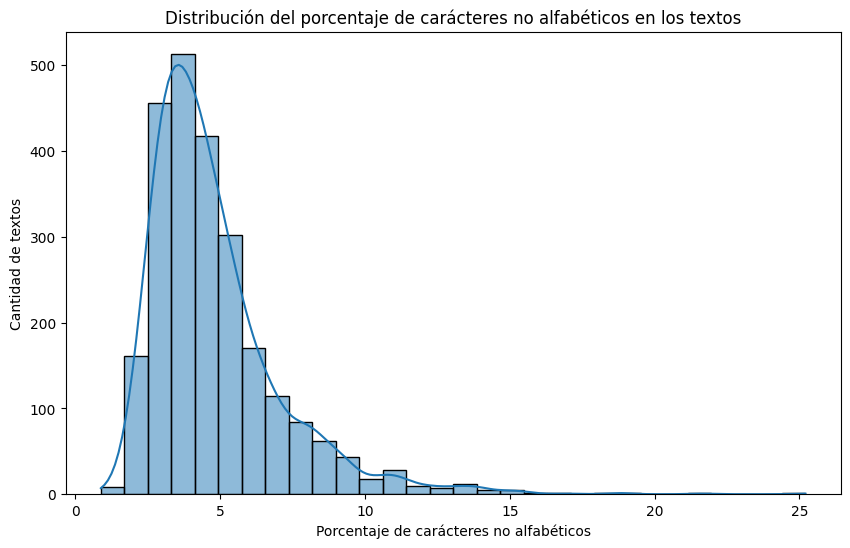

,special_char_percentage
631,25.208681
1695,21.644295
524,18.823529
546,18.701095
550,16.964286
...,...
1280,1.473297
144,1.417004
1367,1.360544
881,1.272265


Estadísticas descriptivas del porcentaje de carácteres no alfabéticos por texto:
count    2424.000000
mean        4.800697
std         2.289457
min         0.878294
25%         3.276147
50%         4.240919
75%         5.604861
max        25.208681
Name: special_char_percentage, dtype: float64


In [10]:
import dis


special_char_percentages = [(len(na_chars)/total)*100 for na_chars, total in zip(text_non_alpha_chars, text_character_counts)]

special_char_percentages_df = pd.DataFrame({
    'special_char_percentage': special_char_percentages
})

plt.figure(figsize=(10, 6))
sns.histplot(special_char_percentages_df['special_char_percentage'], bins=30, kde=True)
plt.title('Distribución del porcentaje de carácteres no alfabéticos en los textos')
plt.xlabel('Porcentaje de carácteres no alfabéticos')
plt.ylabel('Cantidad de textos')
plt.show()

special_char_percentages_df.sort_values(by='special_char_percentage', ascending=False, inplace=True)
display(special_char_percentages_df)

print("Estadísticas descriptivas del porcentaje de carácteres no alfabéticos por texto:")
print(special_char_percentages_df['special_char_percentage'].describe())

In [11]:
#TODO: Escribir análisis

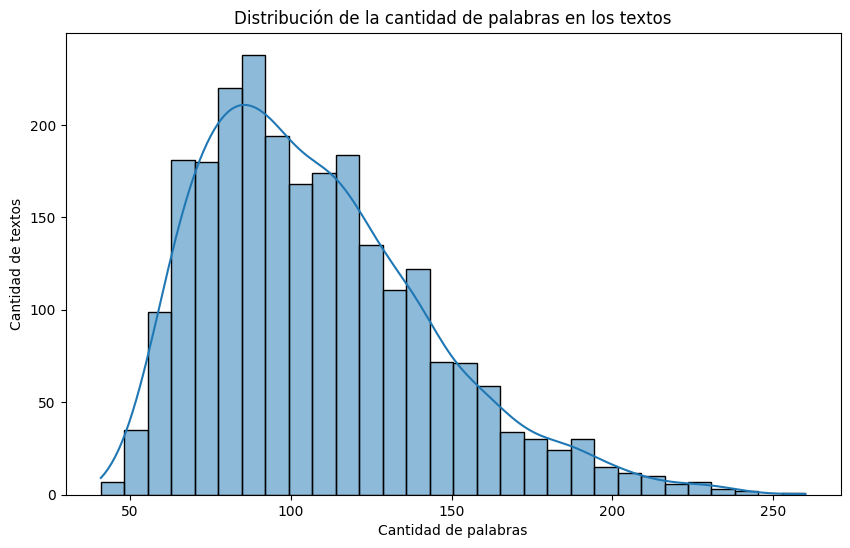

Estadísticas descriptivas de la cantidad de palabras en los textos:
count    2424.000000
mean      107.924092
std        35.575349
min        41.000000
25%        81.000000
50%       102.000000
75%       129.000000
max       260.000000
Name: textos, dtype: float64


In [12]:
text_word_counts = original_data['textos'].str.split().str.len()
plt.figure(figsize=(10, 6))
sns.histplot(text_word_counts, bins=30, kde=True)
plt.title('Distribución de la cantidad de palabras en los textos')
plt.xlabel('Cantidad de palabras')
plt.ylabel('Cantidad de textos')
plt.show()

print("Estadísticas descriptivas de la cantidad de palabras en los textos:")
print(text_word_counts.describe())

In [13]:
#TODO: Completar comentando las estadísticas descriptivas.

La distribución de la longitud de los textos es aproximadamente normal, sin embargo parece tener un sesgo hacia la izquierda.

In [14]:
from langdetect import detect
from collections import Counter

# Detect language for each text
languages = original_data['textos'].apply(lambda x: detect(str(x)))

# Count occurrences of each language
language_counts = Counter(languages)
print(language_counts)

Counter({'es': 2424})


In [15]:
#TODO: Quitar esto si confirman que todo es en español.

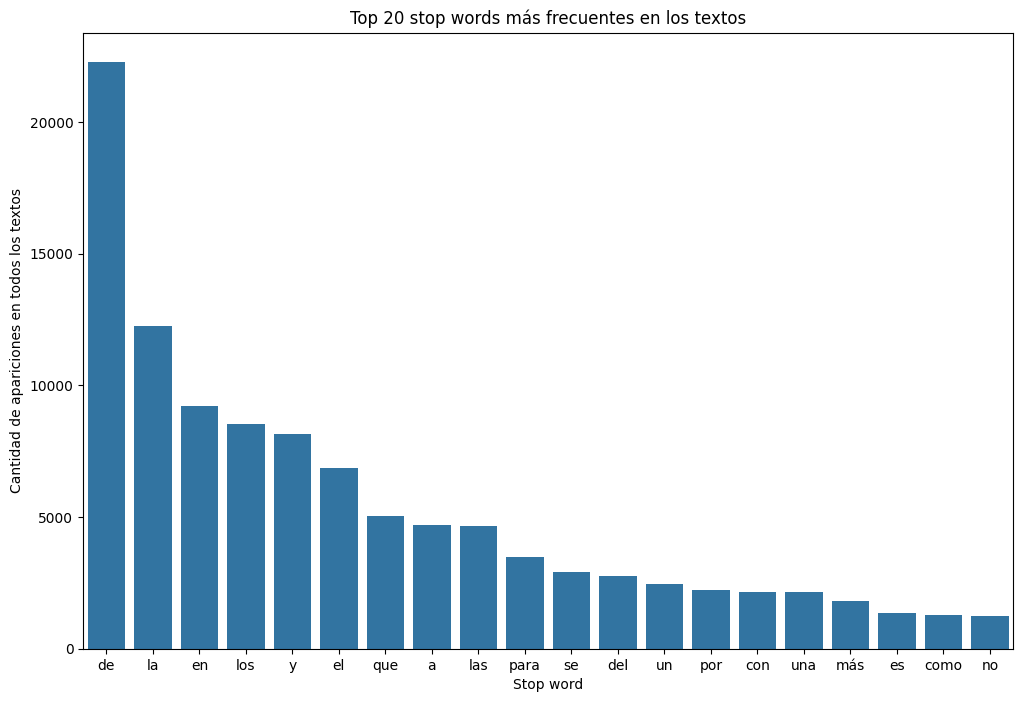

    stop_word  count
0          de  22277
1          la  12256
4          en   9218
7         los   8551
5           y   8137
..        ...    ...
276   tendrás      0
309    tenida      0
310   tenidos      0
311   tenidas      0
312     tened      0

[313 rows x 2 columns]
Estadísticas descriptivas de la cantidad de apariciones de stop words:
count      313.000000
mean       393.067093
std       1793.521058
min          0.000000
25%          0.000000
50%          1.000000
75%         50.000000
max      22277.000000
Name: count, dtype: float64


In [16]:
stop_word_counts = {word: original_data['textos'].str.count(rf'\b{re.escape(word)}\b', flags=re.IGNORECASE).sum() for word in stop_words}
stop_word_counts_df = pd.DataFrame(list(stop_word_counts.items()), columns=['stop_word', 'count']).sort_values(by='count', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=stop_word_counts_df.head(20), x='stop_word', y='count')
plt.title('Top 20 stop words más frecuentes en los textos')
plt.xlabel('Stop word')
plt.ylabel('Cantidad de apariciones en todos los textos')
plt.show()

print(stop_word_counts_df)

print("Estadísticas descriptivas de la cantidad de apariciones de stop words:")
print(stop_word_counts_df['count'].describe())

Hay una cantidad significativa de stop words en los textos, lo cual es esperado en textos que corresponden a las opiniones de personas. Esto también es importante tenerlo en cuenta al momento de normalizar los textos.

In [17]:
#TODO: Ver por texto el porcentaje de stop words respecto al total de palabras.

### **Análisis de Calidad de Datos**

#### **Completitud**

In [18]:
print("Valores nulos por columna:")
print(original_data.isnull().sum())

Valores nulos por columna:
textos    0
labels    0
dtype: int64


No hay valores nulos en ninguna de las columnas.

#### **Unicidad**

In [19]:
print("Cantidad de textos duplicados:")
print(original_data['textos'].duplicated().sum())

Cantidad de textos duplicados:
0


No hay textos duplicados. Note que no se revisan duplicados en labels porque esta variable corresponde a las clases.

#### **Consistencia**

En este caso, no hay nada que evaluar en consistencia. No es posible juzgar si los textos son consistentes con las clases asignadas y no hay otras columnas que deban ser consistentes entre sí.

#### **Validez**

In [20]:
print("Conteo de valores de labels:")
print(original_data['labels'].value_counts())

Conteo de valores de labels:
labels
4    1025
3     894
1     505
Name: count, dtype: int64


Efectivamente solo están las clases 1, 3 y 4 en la variable objetivo.

In [21]:
original_data['textos'] = original_data['textos'].astype('string')

Se cambia el tipo de dato de la columna 'textos' para que sea explícitamente de tipo string.

In [22]:
print("Tipos de datos por columna:")
print(original_data.dtypes)

Tipos de datos por columna:
textos    string[python]
labels             int64
dtype: object


### **Preparación**

Opciones interesantes:
- Reemplazar caracteres especiales relevantes como tildes, ñ, acentos, etc por caracteres alfabéticos correspondientes. Se podría dejar ñ?
- Cambiar caracteres numéricos por su representación en letras o eliminar números.
- Lematizar verbos por sus terminaciones de forma manual.
- Las contracciones no creo que sean suficientemente relevantes como para hacer un diccionario de reemplazo. Aparecen en las stops words?

Obligatorio:
- Pasar todo a minúsculas.
- Eliminar carácteres especiales irrelevantes.
- Lematización o stemming con librería, pero a priori me suena mejor lematización.
- Eliminar stop words.
- Eliminar no alfabéticos. Será que conviene dejar puntuación? Si se deja puntuación se eliminan caracteres especiales irrelevantes cambiandolos por espacios?
- Se vectoriza de una vez? Creería que sí, pero supongo que es posible que esa representación dependa del algoritmo de clasificación que se use.

Se podrían hacer funciones para que cada uno pruebe con diferentes combinaciones de las opciones anteriores y ver cuál da mejores resultados. No obstante, para stemming, lematización, stop words y vectorización se usarán las librerías estándar y no me complicaré en hacer funciones propias.

In [23]:
nltk.download('punkt')
nltk.download('punkt_tab')

def remove_accents(text: str) -> str:
    normalized = unicodedata.normalize('NFD', text)
    without_accents = ''.join(c for c in normalized if unicodedata.category(c) != 'Mn')
    return without_accents

def replace_numbers_with_text(text: str) -> str:
    num_map = {
        '0': 'cero',
        '1': 'uno',
        '2': 'dos',
        '3': 'tres',
        '4': 'cuatro',
        '5': 'cinco',
        '6': 'seis',
        '7': 'siete',
        '8': 'ocho',
        '9': 'nueve'
    }
    return re.sub(r'\d', lambda m: num_map[m.group()], text)

# -----------------------
# Normalización, tokenización, stemming (NLTK)
# -----------------------
stemmer = SnowballStemmer("spanish")
spanish_stopwords = set(stopwords.words("spanish"))

def basic_normalize(text: str) -> str:
    """Limpieza determinista: lowercase, quitar acentos, números->texto, eliminar no-letras."""
    if text is None:
        return ""
    text = str(text).lower().strip()
    text = remove_accents(text)
    text = replace_numbers_with_text(text)
    # dejar solo letras a-z y espacios (ya quitamos acentos)
    text = re.sub(r'[^a-z\s]', ' ', text, flags=re.UNICODE)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_text(text: str):
    """Tokeniza usando word_tokenize (PUNKT)."""
    if not text:
        return []
    # word_tokenize admite parámetro language, facilita algunos casos
    return word_tokenize(text, language='spanish')

def stem_tokens(tokens, remove_sw: bool = False):
    """Aplica SnowballStemmer a la lista de tokens. Opcionalmente quita stopwords."""
    if remove_sw:
        tokens = [t for t in tokens if t not in spanish_stopwords]
    return [stemmer.stem(t) for t in tokens if t.strip()]

def process_text_once(text: str, remove_stopwords: bool = False) -> str:
    """Pipeline por texto: normalize -> tokenize -> optional stopwords -> stem -> join."""
    basic = basic_normalize(text)
    toks = tokenize_text(basic)
    stems = stem_tokens(toks, remove_sw=remove_stopwords)
    return " ".join(stems)

def normalize_texts_nltk(series: pd.Series, remove_stopwords: bool = False) -> pd.Series:
    """Aplica process_text_once a una pd.Series de textos de forma segura."""
    series = series.fillna("").astype(str)
    return series.apply(lambda s: process_text_once(s, remove_stopwords=remove_stopwords))

df = original_data.copy()

df['text_processed'] = normalize_texts_nltk(df['textos'], remove_stopwords=True)

X = df['text_processed']
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ya puedes entrenar vectorizadores / clasificadores usando X_train (fit) y evaluar en X_test (transform)
print("Tamaños:", len(X_train), len(X_test))
print("Ejemplo procesado:", X_train.iloc[0])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juanc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\juanc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Tamaños: 1939 485
Ejemplo procesado: letoni mov direccion plan desarroll atencion primari salud esfuerz mejor calid accesibil servici salud mejor activ prevent evit person recib atencion hospitalari mas costos letoni demostr pued utiliz fuerz laboral maner innov mejor acces atencion primari necesit fortalec papel desempen medic cabecer profesional salud promocion salud particul educ pacient autocontrol enfermedad cronic seccion tres describ estructur sistem atencion primari salud letoni fuerz laboral desafi


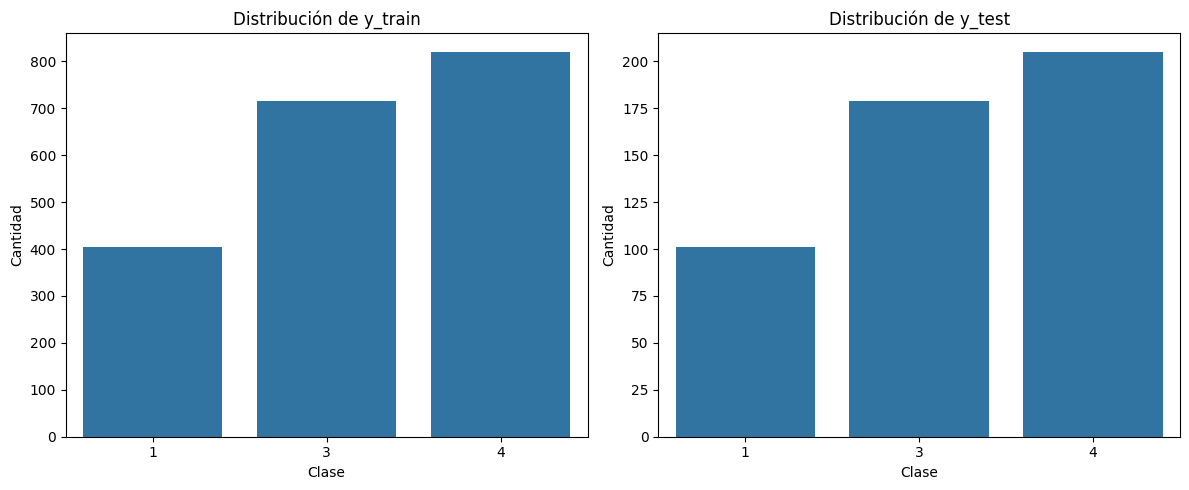

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title('Distribución de y_train')
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Cantidad')

sns.countplot(x=y_test, ax=axes[1])
axes[1].set_title('Distribución de y_test')
axes[1].set_xlabel('Clase')
axes[1].set_ylabel('Cantidad')

plt.tight_layout()
plt.show()

In [25]:
print("Proporciones porcentuales de cada clase en y_train:")
print(y_train.value_counts(normalize=True) * 100)

print("\nProporciones porcentuales de cada clase en y_test:")
print(y_test.value_counts(normalize=True) * 100)

Proporciones porcentuales de cada clase en y_train:
labels
4    42.289840
3    36.874678
1    20.835482
Name: proportion, dtype: float64

Proporciones porcentuales de cada clase en y_test:
labels
4    42.268041
3    36.907216
1    20.824742
Name: proportion, dtype: float64


In [26]:
# Vectorizador elegido: TF-IDF con 1-gram+2-gram
vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=50000,   # opcional: cap para controlar dimensionalidad (cantidad de features)
    min_df=2,             # opcional: ignora tokens muy raros
    norm='l2',
    sublinear_tf=True
)

# Fit SOLO en train, luego transformar train/test
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

print("Shapes: X_train", X_train_tfidf.shape, "X_test", X_test_tfidf.shape)

Shapes: X_train (1939, 16145) X_test (485, 16145)


In [27]:
type(X_train_tfidf)

scipy.sparse._csr.csr_matrix

In [28]:
feature_names = vectorizer.get_feature_names_out()
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=feature_names, index=X_train.index)
display(X_train_tfidf_df.head())

,abaj,abaj haci,abandon,abandon escol,abandon escuel,abandon estudi,abandon profesion,abandon program,abarc,abarqu,...,xxi inclu,york,york oxford,young,zeland,zeland tambi,zon,zon remot,zon rural,zon urban
2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
1708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.104461,0.0,0.115714,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
1884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0


In [29]:
X_test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=feature_names, index=X_test.index)
display(X_test_tfidf_df.head())

,abaj,abaj haci,abandon,abandon escol,abandon escuel,abandon estudi,abandon profesion,abandon program,abarc,abarqu,...,xxi inclu,york,york oxford,young,zeland,zeland tambi,zon,zon remot,zon rural,zon urban
102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.113935,0.0,0.0,0.0,0.0,0.0
1220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [30]:
lowest_index = X_train_tfidf_df.index.min()
row_lowest_index = X_train_tfidf_df.loc[lowest_index]
nonzero_columns = row_lowest_index[row_lowest_index != 0]
print(nonzero_columns)

acuerd              0.176730
aprendizaj          0.119333
auxiliar            0.251319
cad                 0.119333
cad vez             0.173810
comprension         0.200106
consider            0.212139
docent              0.127300
editorial           0.272550
educ                0.141902
escolariz           0.215489
establec            0.140480
examin              0.181579
extension           0.241785
formacion           0.135051
formacion docent    0.213438
formal              0.190261
gobi                0.182452
inadecu             0.219957
junt                0.169186
marc                0.152379
mas                 0.066242
organiz             0.250360
vez                 0.144803
vez mas             0.182452
vuelt               0.241785
vuelt cad           0.283464
Name: 0, dtype: float64


**RESUMEN PARA USAR DATOS ENTRENAMIENTO Y TEST**

In [31]:
type(X_train), type(X_test), type(y_train), type(y_test)

(pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [32]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1939,), (485,), (1939,), (485,))

Los datos preprocesados, pero sin vectorizar están en los dataframes X_train, X_test, y_train, y_test.

In [33]:
df_train = X_train_tfidf_df
df_test = X_test_tfidf_df

Los datos vectorizados están en los dataframes df_train y df_test, pero sus estiquetas siguen en y_train y y_test.

Se usó tf-idf con 1-gramas y 2-gramas para vectorizar los textos tras hacer normalización, i.e. pasar a minúsculas, cambiar letras con tíldes y acentos a letras normales, eliminar caracteres especiales, eliminar stop words y stemmizar. Se usó train_test_split con stratify para dividir los datos en entrenamiento y test, con un 80% de los datos para entrenamiento y un 20% para test manteniendo las proporciones de porcentaje de registros por clase en cada conjunto de datos.

In [34]:
print(df_train.shape)
display(df_train.head())

(1939, 16145)


,abaj,abaj haci,abandon,abandon escol,abandon escuel,abandon estudi,abandon profesion,abandon program,abarc,abarqu,...,xxi inclu,york,york oxford,young,zeland,zeland tambi,zon,zon remot,zon rural,zon urban
2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
1708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.104461,0.0,0.115714,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
1884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0


In [35]:
print(df_test.shape)
display(df_test.head())

(485, 16145)


,abaj,abaj haci,abandon,abandon escol,abandon escuel,abandon estudi,abandon profesion,abandon program,abarc,abarqu,...,xxi inclu,york,york oxford,young,zeland,zeland tambi,zon,zon remot,zon rural,zon urban
102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.113935,0.0,0.0,0.0,0.0,0.0
1220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


### Algoritmo de k vecinos

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Mejores hiperparámetros encontrados: {'knn__metric': 'euclidean', 'knn__n_neighbors': 15, 'knn__weights': 'distance', 'tfidf__ngram_range': (1, 2)}
CV f1_macro: 0.9611021043224973
------------------ Métricas en train ------------------
accuracy: 0.965
balanced_acc: 0.961
f1_macro: 0.961
f1_weighted: 0.965

Reporte por clase:
               precision    recall  f1-score   support

           1      0.941     0.941     0.941       101
           3      0.972     0.972     0.972       179
           4      0.971     0.971     0.971       205

    accuracy                          0.965       485
   macro avg      0.961     0.961     0.961       485
weighted avg      0.965     0.965     0.965       485



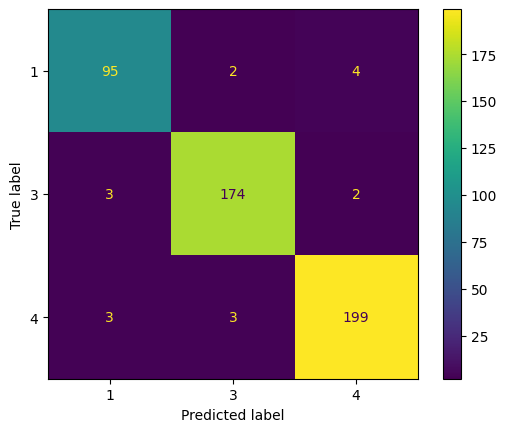

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, balanced_accuracy_score, accuracy_score

pipe_knn = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(
        lowercase=True,
        ngram_range=(1,1),
        min_df=2
    )),
    ('knn', KNeighborsClassifier())
])

param_grid_knn = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'knn__n_neighbors': [3, 5, 7, 11, 15],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['cosine', 'euclidean']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe_knn,
    param_grid=param_grid_knn,
    scoring='f1_macro',
    cv=cv, n_jobs=-1, verbose=1
)

grid.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:", grid.best_params_)
print("CV f1_macro:", grid.best_score_)
best_knn = grid.best_estimator_

print("------------------ Métricas en train ------------------")
y_pred_knn = best_knn.predict(X_test)
print("accuracy:", round(accuracy_score(y_test, y_pred_knn), 3))
print("balanced_acc:", round(balanced_accuracy_score(y_test, y_pred_knn), 3))
print("f1_macro:", round(f1_score(y_test, y_pred_knn, average='macro'), 3))
print("f1_weighted:", round(f1_score(y_test, y_pred_knn, average='weighted'), 3))
print("\nReporte por clase:\n", classification_report(y_test, y_pred_knn, digits=3))

cm = confusion_matrix(y_test, y_pred_knn, labels=best_knn.classes_)
ConfusionMatrixDisplay(cm, display_labels=best_knn.classes_).plot(xticks_rotation=0)